In [3]:
# import thư viện cần thiết
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import signal
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
import sys
import os

# lấy đường dẫn notebook hiện tại
notebook_dir = os.getcwd()  # ví dụ: .../eda
project_path = os.path.abspath(os.path.join(notebook_dir, '..'))  # thư mục cha = project root

if project_path not in sys.path:
    sys.path.append(project_path)
from down_data.stock_data import StockData

# Thu thập dữ liệu

In [5]:
FPT = StockData("FPT.VN", "2023-01-01", "2025-01-01") # khởi tạo cổ phiếu của FPT từ 1/1/2023 - 1/1/2025
data_FPT = FPT.fetch()
print(data_FPT.head(2).T)
for name, values in FPT.get_basic_info().items():
    print(f"{name}: {values}")

[*********************100%***********************]  1 of 1 completed


Date                2023-01-03    2023-01-04
Price     Ticker                            
Adj Close FPT.VN  5.042374e+04  5.042374e+04
Close     FPT.VN  5.260130e+04  5.260130e+04
High      FPT.VN  5.260130e+04  5.325882e+04
Low       FPT.VN  5.049725e+04  5.214104e+04
Open      FPT.VN  5.056300e+04  5.312731e+04
Volume    FPT.VN  2.334845e+06  1.208029e+06
Ten_cong_ty: FPT CORPORATION
Nganh: Information Technology Services
PE: 20.491802
PB: 4.7976904
EPS: 4919.04
ROE: 0.27465


### Nhận xét:
Tên công ty: FPT CORPORATION \
Tất cả chỉ số đều cao, ROE ~27%\
Công ty được kỳ vọng cao, sử dụng nguồn vốn đầu tư có hiệu quả, ổn định

# Khám phá dữ liệu

Mục đích để khám phá dữ liệu, và tránh ảnh hưởng đến dữ liệu gốc, ta tạo một dataframe copy

In [6]:
df = data_FPT.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2023-01-03 to 2024-12-31
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, FPT.VN)  499 non-null    float64
 1   (Close, FPT.VN)      499 non-null    float64
 2   (High, FPT.VN)       499 non-null    float64
 3   (Low, FPT.VN)        499 non-null    float64
 4   (Open, FPT.VN)       499 non-null    float64
 5   (Volume, FPT.VN)     499 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.3 KB


Dữ liệu gồm 6 cột: 
- Adj close (giá đóng điều chỉnh)
- close (giá đóng cửa)
- open (giá mở cửa)
- hight (giá cao nhất phiên)
- low (giá thấp nhất phiên)
- volume (khối lượng giao dịch)

Và 499 quan trắc, không có giá trị null

# Phân tích mối quan hệ tuyến tính

In [8]:
df.columns = df.columns.get_level_values(0)

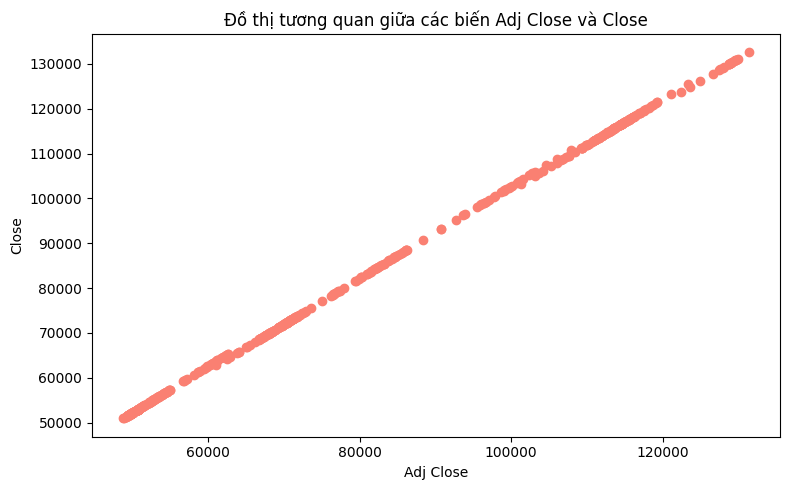

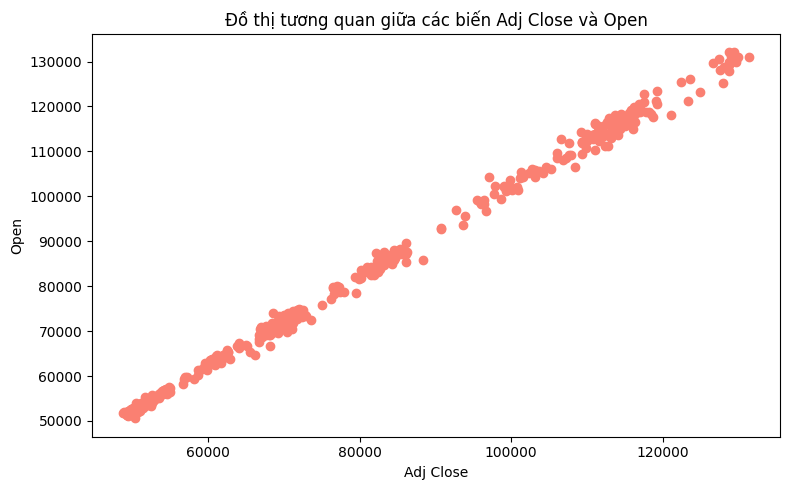

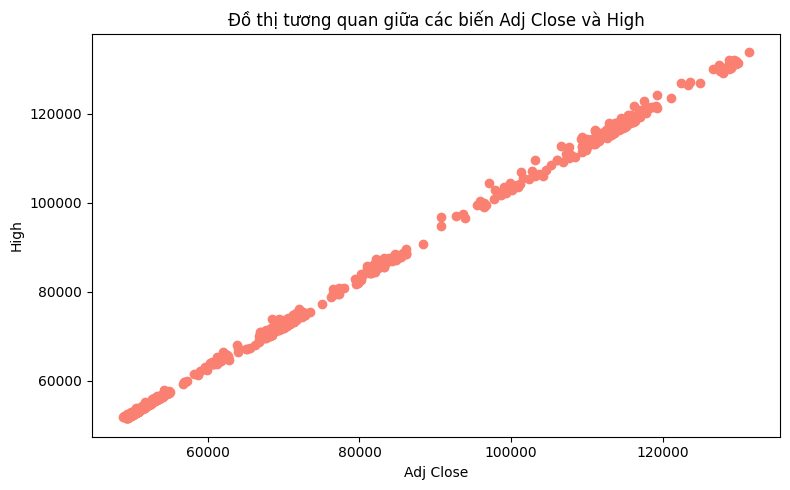

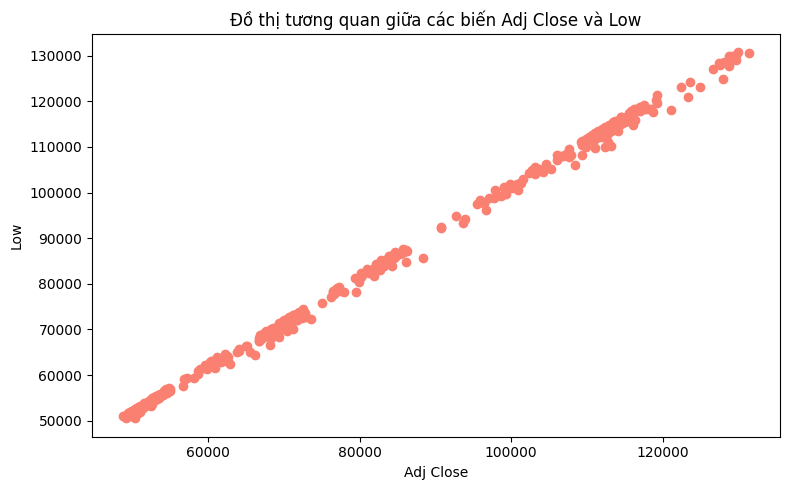

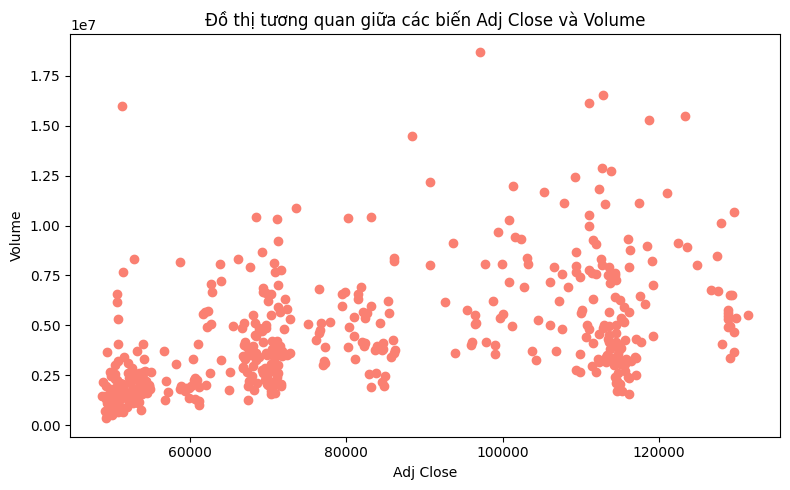

In [9]:
# vẽ đồ thị tương quan giữa adj close và các cột còn lại 
col = ["Close", "Open", "High", "Low", "Volume"] # các cột muốn so sánh
for c in col:
    plt.figure(figsize=(8,5))
    plt.scatter(df["Adj Close"], df[c], color = "salmon")
    plt.xlabel("Adj Close")
    plt.ylabel(f"{c}")
    plt.title(f"Đồ thị tương quan giữa các biến Adj Close và {c}")
    plt.tight_layout()
    plt.show()

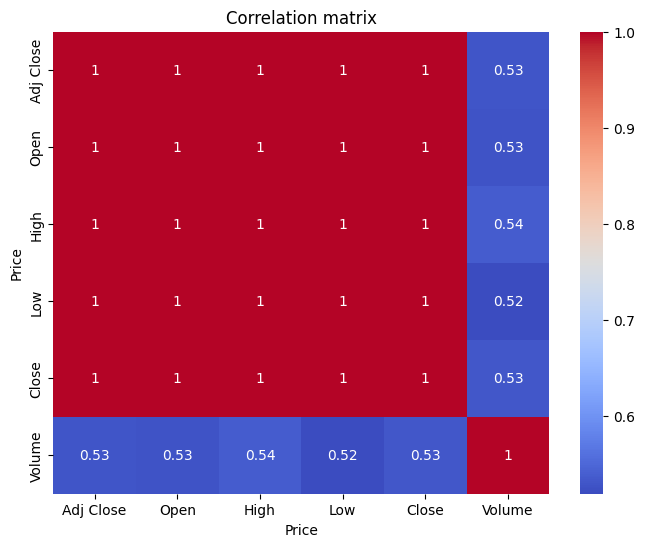

In [10]:
# heatmap 
corr = df[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Phân tích dữ liệu thời gian

## Kiểm tra xu hướng

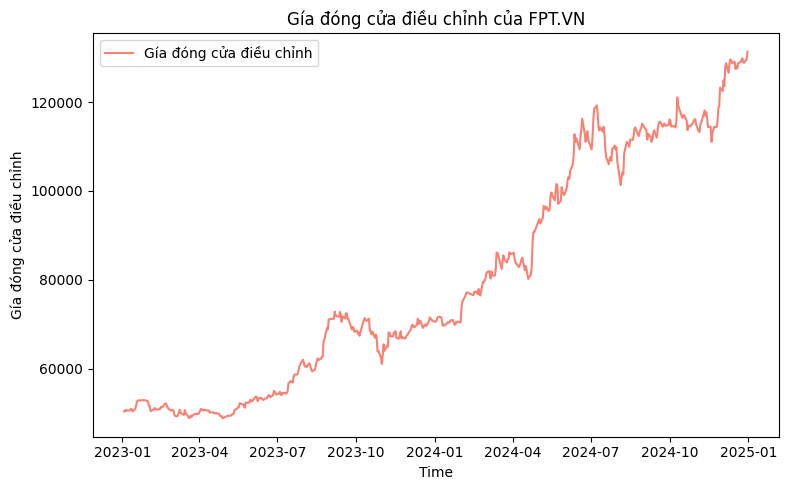

In [11]:
# Ta quan tâm đến giá đóng cửa điều chỉnh (Adj close)
adj = df['Adj Close']
plt.figure(figsize=(8,5))
plt.plot(adj, label = "Gía đóng cửa điều chỉnh", color = 'salmon')
plt.title("Gía đóng cửa điều chỉnh của FPT.VN")
plt.xlabel("Time")
plt.ylabel("Gía đóng cửa điều chỉnh")
plt.legend()
plt.tight_layout()
plt.show()

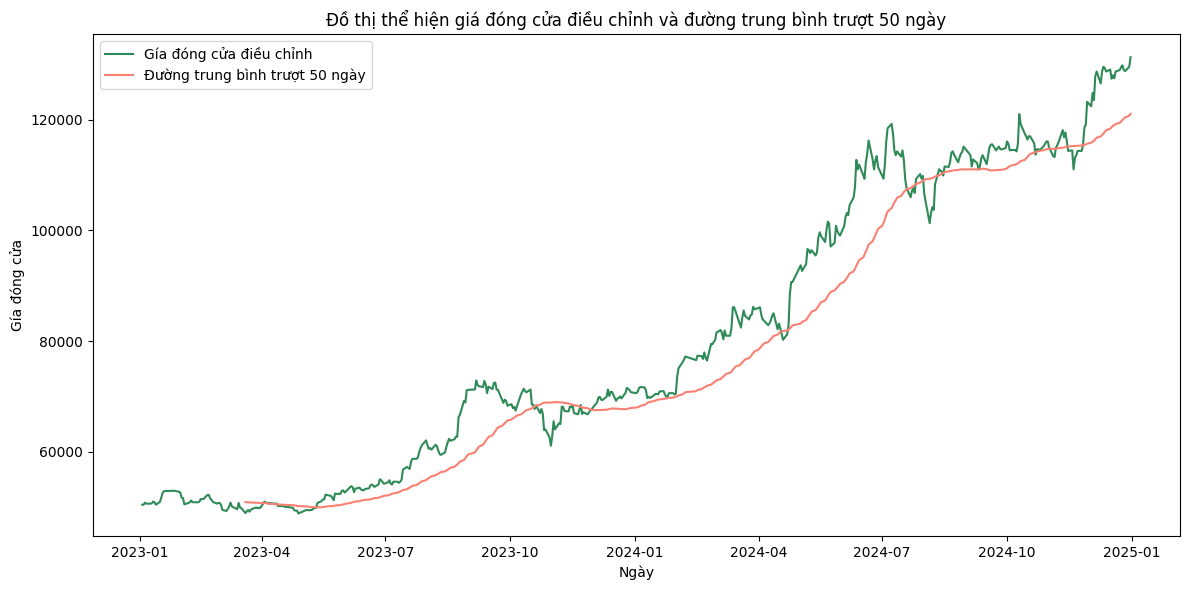

In [12]:
# dùng moving avarage để làm mượt dữ liệu để xem xu hướng 
adj = df['Adj Close']
ma_50 = adj.rolling(window=50).mean() # trung bình trượt 50 ngày 
plt.figure(figsize=(12,6))
plt.plot(adj, label = "Gía đóng cửa điều chỉnh", color = "seagreen")
plt.plot(ma_50, label = "Đường trung bình trượt 50 ngày", color = "salmon")
plt.title("Đồ thị thể hiện giá đóng cửa điều chỉnh và đường trung bình trượt 50 ngày")
plt.xlabel("Ngày")
plt.ylabel("Gía đóng cửa")
plt.legend()
plt.tight_layout()
plt.show()

Xu hướng tăng 

## Phân rã thời gian

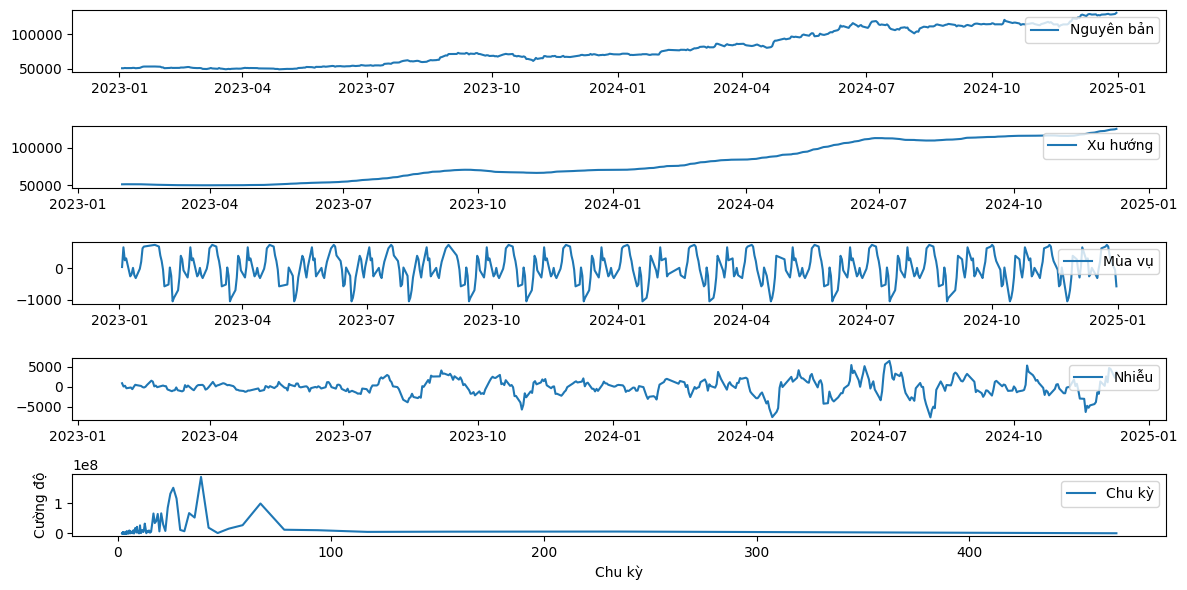

In [13]:
adj = df["Adj Close"] # cột phân tích
decomposition = seasonal_decompose(adj, model= "additive", period=30)
seasonal_val = decomposition.seasonal
trend_val = decomposition.trend
residual = decomposition.resid

# phân tích chu kỳ từ phần dư
residual_clean = residual.dropna()
# sử dụng perioddogram để phân tích chu kỳ
frequencies, power = signal.periodogram(residual_clean) 
# chuyển đổi tần số thành chu kỳ, loại bỏ tần số 0
mask = frequencies > 0
frequencies = frequencies[mask] # tần số dao động 
power = power[mask]
periods = 1 / frequencies

# vẽ các thành phần 
plt.figure(figsize=(12, 6))

# nguyên bản 
plt.subplot(5, 1, 1)
plt.plot(adj, label = "Nguyên bản")
plt.legend(loc="upper right")

# xu hướng 
plt.subplot(5, 1, 2)
plt.plot(trend_val, label = "Xu hướng")
plt.legend(loc="upper right")

# mùa vụ
plt.subplot(5, 1, 3)
plt.plot(seasonal_val, label = "Mùa vụ")
plt.legend(loc="upper right")

# Nhiễu
plt.subplot(5, 1, 4)
plt.plot(residual, label = "Nhiễu")
plt.legend(loc="upper right")

# chu kỳ
plt.subplot(5, 1, 5)
plt.plot(periods, power ,label = "Chu kỳ")
plt.xlabel("Chu kỳ")
plt.ylabel("Cường độ")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Xu hướng tăng\
Có tính mùa vụ

## Kiểm tra tính dừng

Một dãy thời gian được gọi là dừng nếu các đặc trưng thống kê (mean, phương sai, tự tương quan) không thay đổi theo thời gian.\
các mô hình như ARIMA, SARIMA,.. giả định đầu vào là chuỗi dừng.\
Nếu không, mô hình có thể học nhầm xu hướng thành "quy luật" => dự báo sai lệch.\
Nếu chuỗi không dừng, ta cần:
- Sai phân (differencing): trừ đi chính nó ở bước chước x[t] - x[t-1]
- Biến đổi log: giảm phương sai
- Loại bỏ xu hướng tuyến tính/ quy luật mùa vụ nếu có
- Kiểm tra tính dừng bằng ADF
+ Null Hypothesis (H0): Dãy không dừng
+ Alternative Hypothesis (H1): Dãy dừng\
Diễn giải kết quả:
- p-value < 0.05 -> bác bỏ H0 -> dãy dừng 
- p-value > 0.05 -> chấp nhận H0 -> dãy không dừng 

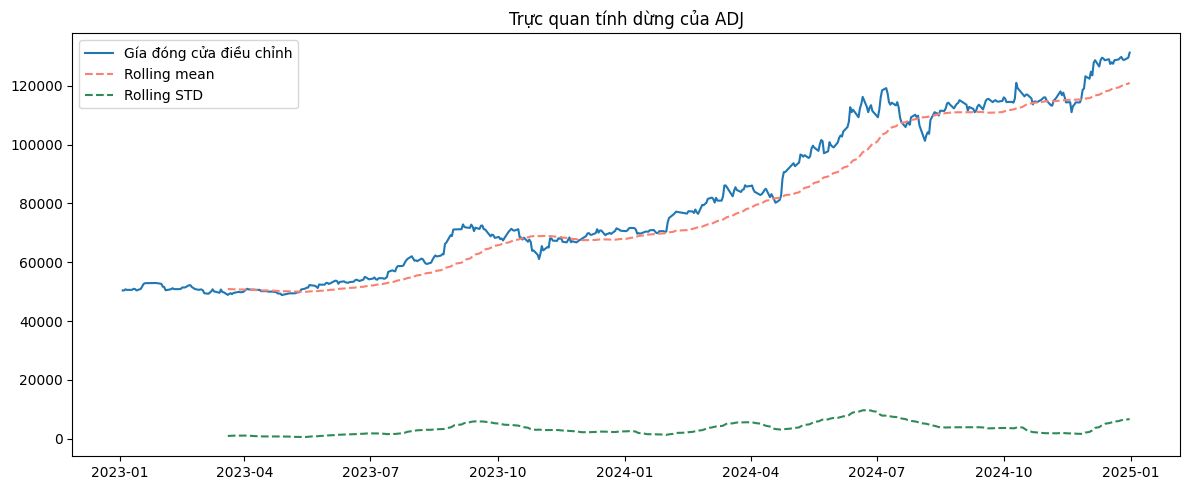

In [14]:
# kiểm tra trực quan tính dừng 
rolling_mean = adj.rolling(window=50).mean()
rolling_std = adj.rolling(window=50).std()

# trực quan 
plt.figure(figsize=(12,5))
plt.plot(adj, label = "Gía đóng cửa điều chỉnh")
plt.plot(rolling_mean, label = "Rolling mean", linestyle = '--', color = 'salmon')
plt.plot(rolling_std, label = 'Rolling STD', linestyle = '--', color = 'seagreen')
plt.title("Trực quan tính dừng của ADJ")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# dùng kiểm định thống kê
from statsmodels.tsa.stattools import adfuller
result = adfuller(adj)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng")

ADF Statistic: 0.5099132441952842
p-value: 0.9851713072071466
Chuỗi không dừng


Điều kiện: Gỉa định chuỗi thời gian là dãy dừng
#### ACF: Hàm tự tương quan 
Đo lường mối tương quan giữa một quan sát với các giá trị trễ (độ trễ - lag) khác nhau của nó.\
VD: Gía hôm nay có liên quan gì đến giá hôm qua (lag = 1),...
#### PACF: Tự tương quan từng phần 
Cũng đô tương quan nhưng loại bỏ ảnh hưởng trung gian từ các độ trễ trước đó.\
VD: PACF tại lag = 2 đo ảnh hưởng trực tiếp từ t-2 đến t, không bị ảnh hưởng bởi t-1\
=> Ta tính toán được các hệ số của AR, MA hay ARMA,... cho huấn luyện mô hình 

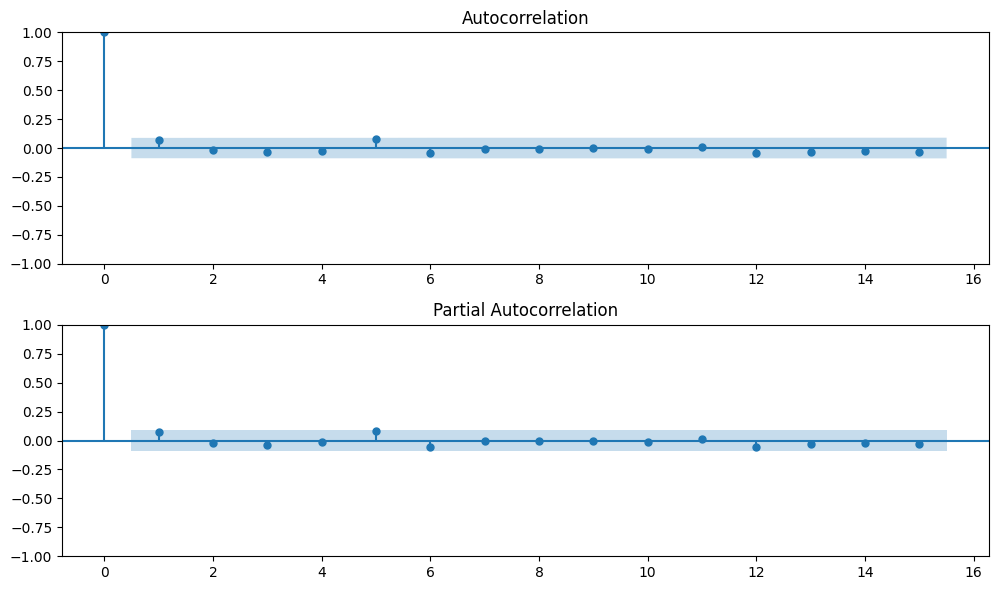

In [16]:
returns = np.log(adj / adj.shift(1)).dropna()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(returns, lags=15, ax=ax[0])
plot_pacf(returns, lags=15, method="ols", ax=ax[1])

plt.tight_layout()
plt.show()

Dữ liệu gần như white noise => nếu train dữ liệu bằng AR/MA/ARMA thì hiệu suất sẽ không cao => không đảm bảo đúng

Tuy nhiên, ta có thể dùng volatility để đánh giá dữ liệu